Drawing started.
Drawing stopped.
Quitting... Predicting the digit.


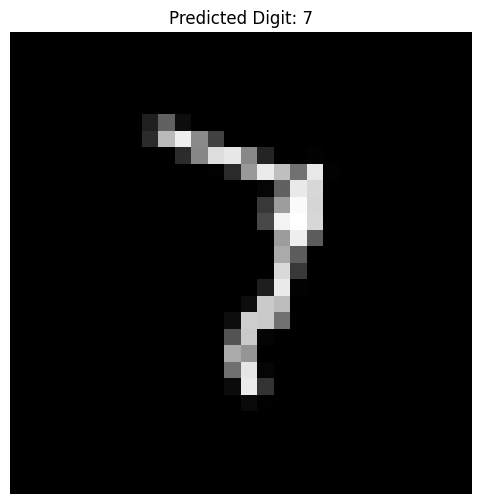

In [1]:
import cv2
import numpy as np
import mediapipe as mp
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

from sklearn.svm import SVC  

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, y = mnist.data, mnist.target
y = y.astype(int)
X = X / 255.0 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

svm_model = SVC(kernel='linear', random_state=42)  
svm_model.fit(X_train, y_train)
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(min_detection_confidence=0.8, min_tracking_confidence=0.8, max_num_hands=1)
mp_draw = mp.solutions.drawing_utils

canvas = np.zeros((300, 300, 3), dtype=np.uint8)
cap = cv2.VideoCapture(0)

drawing = False
prev_x, prev_y = None, None

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame = cv2.flip(frame, 1)
    h, w, _ = frame.shape

    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    result = hands.process(rgb_frame)

    if result.multi_hand_landmarks:
        for hand_landmarks in result.multi_hand_landmarks:
            x, y = int(hand_landmarks.landmark[8].x * w), int(hand_landmarks.landmark[8].y * h)

            canvas_x = int(x * (300 / w))
            canvas_y = int(y * (300 / h))

            cv2.circle(frame, (x, y), 8, (0, 255, 0), -1)

            if drawing:
                if prev_x is not None and prev_y is not None:
                    cv2.line(canvas, (prev_x, prev_y), (canvas_x, canvas_y), (255, 255, 255), 10)
                prev_x, prev_y = canvas_x, canvas_y
            else:
                prev_x, prev_y = None, None

            mp_draw.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)

    cv2.putText(frame, "Press 'S' to Start, 'E' to Stop, 'Q' to Predict", (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

    cv2.imshow("Air Writing", frame)
    cv2.imshow("Canvas", canvas)

    key = cv2.waitKey(1) & 0xFF
    if key == ord('s'):
        drawing = True
        print("Drawing started.")
    elif key == ord('e'):
        drawing = False
        print("Drawing stopped.")
    elif key == ord('q'): 
        print("Quitting... Predicting the digit.")
        break

cap.release()
cv2.destroyAllWindows()

canvas_gray = cv2.cvtColor(canvas, cv2.COLOR_BGR2GRAY)

scale_factor = 1.5 
canvas_gray = np.clip(canvas_gray.astype(float) * scale_factor, 0, 255).astype(np.uint8)

_, thresh = cv2.threshold(canvas_gray, 127, 255, cv2.THRESH_BINARY_INV) 
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

if contours:
    x, y, w, h = cv2.boundingRect(max(contours, key=cv2.contourArea))

    padding = 10  
    x = max(0, x - padding)
    y = max(0, y - padding)
    w = min(canvas_gray.shape[1] - x, w + 2 * padding)
    h = min(canvas_gray.shape[0] - y, h + 2 * padding)

    cropped = canvas_gray[y:y+h, x:x+w]

    if h > w:
        resized = cv2.resize(cropped, (int(28 * w / h), 28), interpolation=cv2.INTER_AREA)
    else:
        resized = cv2.resize(cropped, (28, int(28 * h / w)), interpolation=cv2.INTER_AREA)

    pad_top = (28 - resized.shape[0]) // 2
    pad_bottom = 28 - resized.shape[0] - pad_top
    pad_left = (28 - resized.shape[1]) // 2
    pad_right = 28 - resized.shape[1] - pad_left

    padded = cv2.copyMakeBorder(resized, pad_top, pad_bottom, pad_left, pad_right, cv2.BORDER_CONSTANT, value=0)
else:
    padded = cv2.resize(canvas_gray, (28, 28), interpolation=cv2.INTER_AREA)

canvas_inverted = padded

canvas_normalized = canvas_inverted / 255.0

test_sample = canvas_normalized.reshape(1, -1) 

predicted_digit = svm_model.predict(test_sample)

plt.figure(figsize=(6, 6))
plt.imshow(canvas_inverted, cmap='gray')
plt.axis('off')
plt.title(f"Predicted Digit: {predicted_digit[0]}")
plt.show()